
# Processus Gaussiens - Implémentation Manuelle

Ce notebook implémente un processus gaussien de manière **manuelle**, avec une fonction de noyau RBF paramétrable.
Il permet :
- de modifier les paramètres du noyau (longueur de corrélation, variance),
- d'observer leur impact sur la prédiction,
- de projeter les sorties sur un domaine contraint.

---


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider


In [8]:
def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)


In [13]:

def gp_predict_manual(X_train, y_train, X_test, kernel, kernel_params, sigma_y=1e-8):
    K =kernel(X_train, X_train, **kernel_params) + sigma_y**2 * np.eye(len(X_train))
    K += 1e-8 * np.eye(len(K))  # Ajout de jitter pour la stabilité numérique

    K_s = kernel(X_train, X_test, **kernel_params)
    K_ss = kernel(X_test, X_test, **kernel_params)

    K_inv = np.linalg.inv(K)

    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, np.sqrt(np.diag(cov_s))


In [12]:

# Données d'entraînement
n = 30
X_train = np.sort(6 * np.random.rand(n, 1) - 3, axis=0)
y_train = np.sin(X_train).ravel() + 0.2 * np.random.randn(n)

# Points de test
X_test = np.linspace(-5, 5, 200).reshape(-1, 1)


@interact(length_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Length Scale'),
          sigma_f=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Sigma_f'))
def update_gp(length_scale=1.0, sigma_f=1.0):
    params = {"length_scale": length_scale, "sigma_f": sigma_f} # Paramètres du noyau RBF
    mu, std = gp_predict_manual(X_train, y_train, X_test, rbf_kernel, params)

    # Vraie fonction
    f_true = np.sin(X_test).ravel()

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f_true, 'b--', label='Vraie fonction $f(x) = \sin(x)$')
    plt.plot(X_test, mu, 'r-', label='Prédiction moyenne GP')
    plt.fill_between(X_test.ravel(), mu - 2*std, mu + 2*std, color='orange', alpha=0.3, label='Incertitude ±2σ')
    plt.plot(X_train, y_train, 'ko', label='Données d\'entraînement')

    plt.title("Régression avec Processus Gaussien")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.ylim(-2, 2)
    plt.show()



<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hilal\AppData\Local\Temp\ipykernel_16616\1889614015.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(X_test, f_true, 'b--', label='Vraie fonction $f(x) = \sin(x)$')


interactive(children=(FloatSlider(value=1.0, description='Length Scale', max=5.0, min=0.1), FloatSlider(value=…

Remarquons que Quand length_scale → 0, le noyau RBF devient presque nul sauf quand 𝑥=𝑥′, donc la matrice de covariance 𝐾 devient presque diagonale → mal conditionnée → instabilité à l’inversion.
Dans ce cas, la moyenne prédite saute partout et l’incertitude explose.

Voyons maintenant ce qu'il se passe si le domaine d'entrée est contraint

C:\Users\hilal\AppData\Local\Temp\ipykernel_16616\3984957878.py:13: RuntimeWarning: invalid value encountered in sqrt
  return mu_s, np.sqrt(np.diag(cov_s))


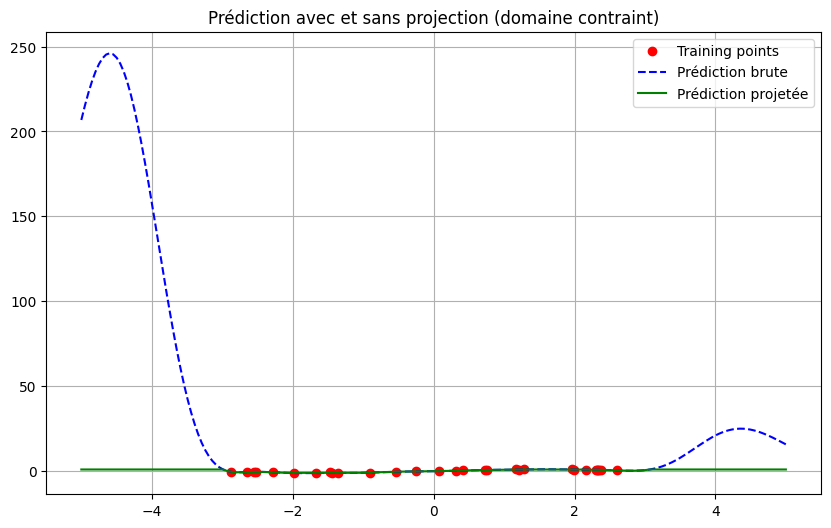

In [15]:

# Domaine contraint
domain_min, domain_max = -1, 1

# Calculer mu en utilisant les paramètres du noyau RBF
kernel_params = {"length_scale": 1.0, "sigma_f": 1.0}  # Exemple de paramètres
mu, _ = gp_predict_manual(X_train, y_train, X_test, rbf_kernel, kernel_params)

# Projection
mu_projected = np.clip(mu, domain_min, domain_max)

plt.figure(figsize=(10,6))
plt.plot(X_train, y_train, 'ro', label='Training points')
plt.plot(X_test, mu, 'b--', label='Prédiction brute')
plt.plot(X_test, mu_projected, 'g-', label='Prédiction projetée')
plt.title("Prédiction avec et sans projection (domaine contraint)")
plt.legend()
plt.grid(True)
plt.show()


Il semblerait que contraindre le domaine d'entrée conduise à...